<a href="https://colab.research.google.com/github/gvozdila/kaggle-xray/blob/FastAI/MultiLabelClassification_FastAI_%D0%A7%D0%B5%D1%80%D0%BD%D0%BE%D0%91%D0%B5%D0%BB%D0%BE%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#для kaggle 
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 27.7 MB/s 
     |████████████████████████████████| 61 kB 7.5 MB/s 
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.4.4
    Uninstalling fastcore-1.4.4:
      Successfully uninstalled fastcore-1.4.4
  Attempting uninstall: fastai
    Found existing installation: fastai 2.6.3
    Uninstalling fastai-2.6.3:
      Successfully uninstalled fastai-2.6.3


In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.4 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

In [3]:
from fastai import *
from fastai.vision.all import *
import numpy as np 
import pandas as pd 




In [5]:
#Лучше еще добавить
import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
train_csv = pd.read_csv ('/content/drive/MyDrive/train.csv')
#classes = list(train_csv.Target.unique())
train_path='/content/drive/MyDrive/train_xray'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip())
test_df = pd.read_csv ('/content/drive/MyDrive/xr/xray/sample_submission.csv')







In [18]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [19]:
train_df.Target.unique()

array(['0', '15', '12', '14', '3', '13 20', '5', '17', '2', '6', '9 21',
       '9', '16', '7', '11', '1', '20', '21', '13', '0 3', '8', '1 11 12',
       '0 15', '19', '10', '4', '11 12', '1 6', '10 19', '5 8', '3 15',
       '7 9', '15 19', '2 13 20', '18', '3 6', '2 20', '10 11 19', '1 12',
       '3 7', '8 16'], dtype=object)

In [20]:
print(train_df.dtypes)

SOPInstanceUID    object
Target            object
dtype: object


In [21]:
#Сделаем Target более читаемым.hip ,thigh в чем разница?
#"thigh - бедренная кость" ?
#"hip - мышца бедра", типа ляжка по нашему?


idx2lbl = {
"0":"Брюшная_полость",
"1":"Лодыжка",
"2":"Шейный_отдел",
"3":"Грудь",
"4":"Ключица",
"5":"Локоть",
"6":"Ноги",
"7":"Палец",
"8":"Предплечье",
"9":"Рука",
"10":"Мышца_бедра",
"11":"Колено",
"12":"Голень",
"13":"Поясничный_отдел",
"14":"Другое",
"15":"Таз",
"16":"Плечо",
"17":"Синус",
"18":"Череп",
"19":"Бедренная_кость",
"20":"Грудной_отдел",
"21":"Запястье",
"13 20":"Поясничный_отдел" "Грудной_отдел",
"9 21":"Рука" "Запястье",
"0 3":"Брюшная_полость" "Грудь",
"1 11 12":"Лодыжка" "Колено" "Голень",
"0 15":"Брюшная_полость" "Таз",
"11 12":"Колено" "Голень",
"1 6":"Лодыжка" "Ноги",
"10 19":"Мышца_бедра" "Бедренная_кость",
"5 8":"Локоть" "Предплечье",
"3 15":"Грудь" "Таз",
"7 9":"Палец" "Рука",
"15 19":"Плечо" "Бедренная_кость",
"2 13 20":"Шейный_отдел" "Поясничный_отдел" "Грудной_отдел",
"3 6":"Грудь" "Ноги",
"2 20":"Шейный_отдел" "Грудной_отдел",
"10 11 19":"мышца_бедра" "Колено" "Бедренная_кость",
"1 12":"Лодыжка" "Голень",
"3 7":"Грудь" "Палец",
"8 16":"Предплечье" "Плечо"

         }

train_df['Target'].replace(idx2lbl, inplace=True)
train_df



,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,Брюшная_полость
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,Таз
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,Голень
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,Другое
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,Грудь
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,Другое
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,Колено
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,Грудь
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,Шейный_отдел


In [22]:
train_df.Target.unique()

array(['Брюшная_полость', 'Таз', 'Голень', 'Другое', 'Грудь',
       'Поясничный_отделГрудной_отдел', 'Локоть', 'Синус', 'Шейный_отдел',
       'Ноги', 'РукаЗапястье', 'Рука', 'Плечо', 'Палец', 'Колено',
       'Лодыжка', 'Грудной_отдел', 'Запястье', 'Поясничный_отдел',
       'Брюшная_полостьГрудь', 'Предплечье', 'ЛодыжкаКоленоГолень',
       'Брюшная_полостьТаз', 'Бедренная_кость', 'Мышца_бедра', 'Ключица',
       'КоленоГолень', 'ЛодыжкаНоги', 'Мышца_бедраБедренная_кость',
       'ЛокотьПредплечье', 'ГрудьТаз', 'ПалецРука',
       'ПлечоБедренная_кость',
       'Шейный_отделПоясничный_отделГрудной_отдел', 'Череп', 'ГрудьНоги',
       'Шейный_отделГрудной_отдел', 'мышца_бедраКоленоБедренная_кость',
       'ЛодыжкаГолень', 'ГрудьПалец', 'ПредплечьеПлечо'], dtype=object)

In [ ]:
#Создаем блок данных на основании шаблона
#dblock = DataBlock(get_x = get_images_name,
#                   get_y = get_target_name)

In [23]:
db = DataBlock (blocks=(ImageBlock, MultiCategoryBlock),  #используем блок данных для мультикатегорий
                   get_x=ColReader(0, #данные по именам изображений у нас хранятся в первом столбце, по логике датафрейма - в нулевом
                                   pref='/content/drive/MyDrive/train_xray/',
                                   suff='-c.bone.jpg'),
                  splitter = RandomSplitter(valid_pct=0.2),  #Сколько данных отложим для валидации.Здесь - 20 процентов
                  
                   get_y=ColReader(1,               #данные по меткам изображений у нас во втором столбце, по логике датафрейма - в первом. 
                                   label_delim=' '  #в случае, если на картинке больше одной метки, они разделены пробелом
                                   ) 
                )                                             
                              
                                  
                   
                
                 

In [24]:
bs=64 #размер батча

In [32]:
item_tfms = [Resize(64)]
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

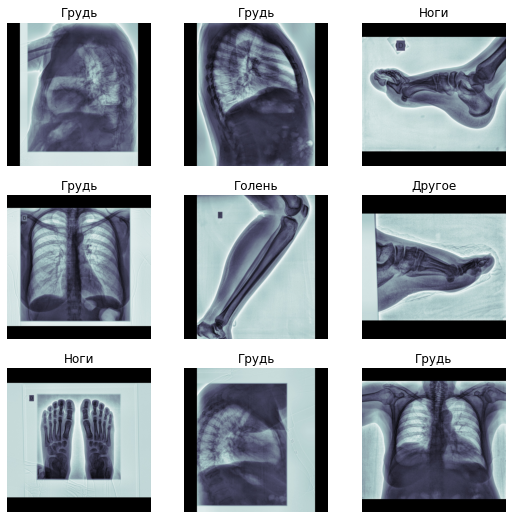

In [33]:
dls = db.dataloaders(train_df)
dls.show_batch()


In [34]:
from fastai.metrics import accuracy_multi

In [35]:
learn = vision_learner(dls, resnet50, pretrained=True, metrics=[accuracy_multi])

In [36]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [37]:
learn.loss_func = BCEWithLogitsLossFlat()

In [38]:
lr = learn.lr_find()
#Решение о том, как изменять наши параметры в зависимости от значений градиентов.является важной частью процесса глубокого обучения. 
#Почти все подходы начинаются с базовой идеи умножения градиента на некоторое небольшое число, называемое скоростью обучения (LR). 
#Часто скорость обучения - это число от 0,001 до 0,1, хотя она может быть любой.
#Если выбрать слишком низкую скорость обучения, это может привести к необходимости выполнения большого количества шагов.
#Но выбор слишком высокой скорости обучения еще хуже - он может привести к увеличению потерь.
#Cyclical Learning Rates for Training Neural Networks,Leslie N. Smith,2015 .

RuntimeError: ignored

In [39]:
learn.fine_tune(5).to_fp16()

epoch,train_loss,valid_loss,accuracy_multi,time


RuntimeError: ignored

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()
lr = learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, lr[0])

In [ ]:
learn.show_results(figsize=(15,15))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,14,13;20,"TensorBase([1.5522e-04, 2.6824e-04, 4.6345e-05, 2.5170e-04, 1.1778e-04, 9.9867e-01,\n 9.8426e-04, 2.2048e-04, 1.8536e-04, 2.0684e-04, 1.1403e-04, 2.2753e-04,\n 4.9670e-04, 9.9916e-01, 5.5430e-04, 6.1553e-05, 1.3252e-04, 2.9001e-04,\n 2.4051e-04, 5.2401e-04, 2.4792e-04, 3.0899e-04])",1.1170159578323364
1,11,6,"TensorBase([1.5353e-04, 2.3152e-04, 2.3333e-04, 9.7213e-05, 1.8315e-04, 2.9413e-04,\n 6.5013e-03, 4.5817e-04, 7.2198e-05, 7.3639e-05, 1.1696e-04, 9.1911e-05,\n 4.2819e-04, 1.7549e-04, 5.9378e-04, 2.0786e-04, 1.9435e-04, 5.4544e-04,\n 9.9781e-01, 9.4884e-05, 3.3180e-04, 1.2841e-04])",0.8078662157058716
2,14,3,"TensorBase([4.0651e-04, 5.4892e-04, 3.1189e-04, 4.4117e-04, 2.7483e-04, 6.1681e-04,\n 4.0234e-04, 1.5784e-03, 1.0780e-03, 1.3838e-04, 2.0224e-04, 3.7486e-04,\n 1.7805e-03, 1.5649e-03, 4.5150e-04, 9.9105e-01, 1.8359e-03, 3.4210e-04,\n 8.4317e-04, 2.7684e-04, 1.7928e-03, 1.3852e-04])",0.6898623704910278
3,10,15,"TensorBase([1.5368e-05, 1.7170e-05, 2.6764e-03, 2.5787e-04, 1.2661e-05, 3.7214e-04,\n 1.3221e-05, 9.8864e-01, 3.9625e-06, 2.8018e-05, 1.8679e-05, 3.8036e-04,\n 5.5873e-06, 2.2129e-04, 8.9269e-05, 3.9506e-05, 1.2662e-05, 6.7429e-05,\n 4.7971e-05, 9.5633e-06, 5.0671e-05, 1.6375e-04])",0.6441553235054016
4,21;9,9,"TensorBase([1.5649e-04, 5.8470e-02, 4.5692e-05, 6.3132e-05, 4.1333e-04, 2.8220e-04,\n 4.0448e-04, 1.0138e-04, 6.9495e-05, 6.6381e-05, 2.5233e-04, 2.2356e-05,\n 6.3206e-05, 3.4273e-04, 2.1746e-02, 3.4481e-03, 3.8776e-04, 3.3649e-05,\n 2.5831e-02, 1.8579e-04, 2.4410e-05, 9.2732e-01])",0.6394892930984497
5,3,2,"TensorBase([4.5929e-04, 2.1342e-04, 7.6946e-05, 5.2082e-05, 1.0300e-04, 8.3730e-04,\n 4.6889e-04, 2.8194e-04, 7.5829e-04, 4.9612e-05, 6.5822e-05, 1.1080e-04,\n 9.9859e-01, 2.5988e-03, 2.3675e-03, 1.5189e-04, 7.7591e-04, 2.4272e-04,\n 3.7676e-04, 1.0705e-04, 5.8589e-05, 8.6613e-05])",0.6163620948791504
6,0,13,"TensorBase([9.4118e-02, 4.2632e-04, 4.0229e-04, 3.7512e-04, 2.3018e-04, 9.4274e-01,\n 6.3939e-04, 9.3894e-05, 8.7182e-05, 1.0904e-04, 3.0366e-04, 2.1697e-04,\n 1.7775e-03, 2.2446e-02, 1.6259e-04, 1.9100e-04, 4.6467e-04, 2.2142e-04,\n 6.2313e-04, 9.8655e-05, 1.7612e-04, 3.4719e-04])",0.5072326064109802
7,21,1,"TensorBase([5.6150e-05, 9.9920e-01, 6.6680e-05, 2.1087e-04, 4.2365e-05, 4.4877e-04,\n 6.8296e-05, 1.0725e-03, 2.0126e-04, 9.4219e-05, 3.9991e-05, 6.5524e-05,\n 1.9661e-05, 1.0961e-04, 1.8092e-03, 7.2432e-05, 5.7237e-05, 1.1807e-04,\n 1.7870e-03, 4.3061e-05, 7.2305e-05, 4.3906e-05])",0.45323053002357483
8,3;7,7,"TensorBase([2.0251e-05, 5.2151e-06, 1.0045e-05, 2.3401e-05, 5.6107e-06, 2.3971e-05,\n 2.3506e-04, 4.6571e-05, 1.0014e-03, 3.9932e-05, 9.0190e-05, 2.7931e-04,\n 1.8310e-05, 5.1141e-05, 1.2154e-01, 7.5148e-05, 4.8790e-05, 1.2920e-05,\n 2.2658e-05, 9.9734e-01, 5.4566e-04, 1.6007e-03])",0.4363264739513397
9,21,1,"TensorBase([5.5267e-05, 9.9331e-01, 2.9739e-05, 1.6435e-04, 2.6285e-05, 3.1793e-04,\n 1.7776e-04, 1.8531e-04, 2.0631e-04, 4.5701e-05, 6.3739e-05, 2.2821e-05,\n 6.0973e-05, 8.9073e-05, 3.6998e-02, 2.2516e-05, 6.0113e-05, 1.6733e-05,\n 9.6443e-04, 2.4071e-05, 5.6584e-05, 4.0106e-05])",0.40225571393966675


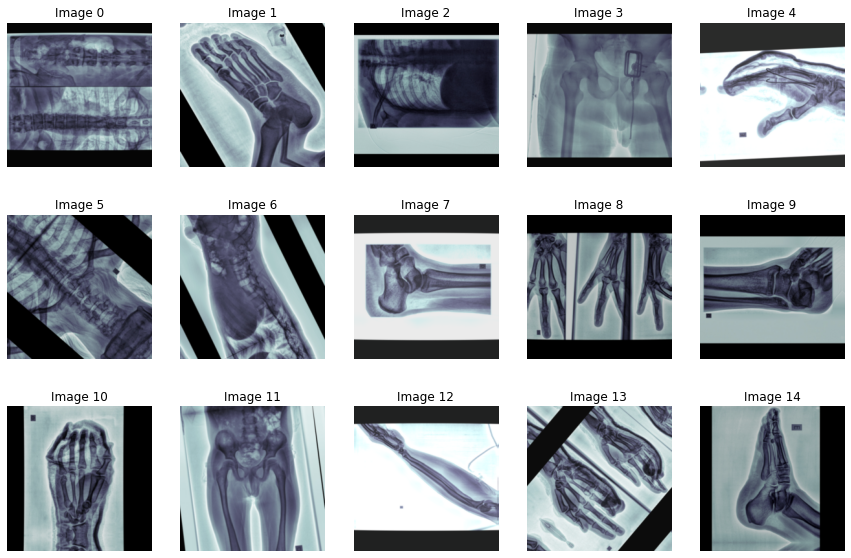

In [ ]:
#посмотрим топ-ошибок.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(15, figsize=(15, 10))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


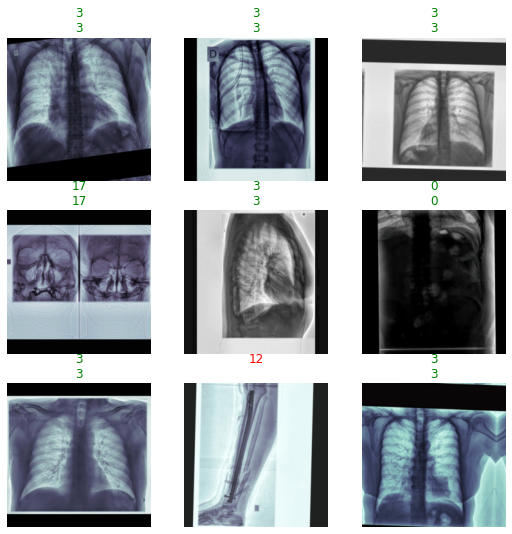

In [ ]:
learn.show_results()